In [ ]:
pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 5.4 kB/s eta 0:00:011
     |████████████████████████████████| 104 kB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 67.6 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 649 kB/s  eta 0:00:01
     |████████████████████████████████| 3.4 MB 51.3 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 56.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 91 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 76.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 73.0 MB/s eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=af6e98902f2e9e797ea

In [ ]:
%%bash

aws s3 sync s3://imageclas-wwc-covid/Train ./Train    
aws s3 sync s3://imageclas-wwc-covid/Validation ./Validation
aws s3 sync s3://imageclas-wwc-covid/Test ./Test

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers,callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import densenet

In [5]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(0)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(42)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(42)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(42)
#tf.set_random_seed(42)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [15]:
data_directory="./"
train_directory=data_directory+"Train/"
validation_directory=data_directory+"Validation/"
test_directory=data_directory+"Test/"
pretrained_weights_file="./densenet.hdf5"

num_classes=len(os.listdir(train_directory))
print("Number of Classes : ",num_classes)
print(os.listdir(train_directory))

Number of Classes :  3
['COVID-19', 'PNEUMONIA BACTERIA', 'NORMAL']


In [ ]:
# Path for Model saving
!mkdir "covidx_model"
save_path = "./covidx_model/"

In [7]:
train_batch_size=32
validation_batch_size=8
test_batch_size=8
target_size=(256,256)
class_mode="categorical"
epochs=25
learning_rate=0.0001

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=3,
                                 brightness_range=(0.6,0.85),
                                 width_shift_range=0.05,
                                 height_shift_range=0.05
)

validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_directory,
    target_size=target_size,
    batch_size=train_batch_size,
    class_mode=class_mode,
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    validation_directory,
    target_size=target_size,
    batch_size=validation_batch_size,
    class_mode=class_mode,
    shuffle=False
)

test_generator=test_datagen.flow_from_directory(
    test_directory,
    target_size=target_size,
    batch_size=test_batch_size,
    class_mode=class_mode,
    shuffle=False
)



Found 1166 images belonging to 3 classes.
Found 146 images belonging to 3 classes.
Found 145 images belonging to 3 classes.


In [ ]:
base_model = densenet.DenseNet121(weights=pretrained_weights_file, include_top=False)
for layer in base_model.layers[:-7]:
  layer.trainable=False
for layer in base_model.layers[-7:]:
  layer.trainable=True

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
model_predictions=Dense(num_classes,activation="softmax")(x)
model=Model(inputs=base_model.input,outputs=model_predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Defining callbacks
checkpoint_callback=callbacks.ModelCheckpoint(os.path.join(save_path,"model_weights.h5"),\
                                                  monitor='val_accuracy',save_weights_only=True, mode='max', verbose=1)
callback_list=[checkpoint_callback]

# Defining optimizer
optimizer=optimizers.Adam(lr=learning_rate)

#Compiling the Model
model.compile(optimizer=optimizer,metrics=["accuracy"],loss="categorical_crossentropy")

#Training the Model
history=model.fit_generator(train_generator,validation_data=validation_generator,epochs=epochs,callbacks=callback_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 1.0767 - accuracy: 0.4648
Epoch 00001: saving model to ./covidx_model/model_weights.h5
37/37 [==============================] - 368s 10s/step - loss: 1.0767 - accuracy: 0.4648 - val_loss: 0.8347 - val_accuracy: 0.6370
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.7067 
Epoch 00002: saving model to ./covidx_model/model_weights.h5
37/37 [==============================] - 599s 16s/step - loss: 0.6817 - accuracy: 0.7067 - val_loss: 0.5776 - val_accuracy: 0.7945
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.7933 
Epoch 00003: saving model to ./covidx_model/model_weights.h5
37/37 [==============================] - 602s 16s/step - loss: 0.5373 - accuracy: 0.7933 - val_loss: 0.4395 - val_accuracy: 0.8493
Epoch 4/25
37/37 [==============================] - ETA: 0s - lo

In [15]:
model.save_weights(os.path.join(save_path,"model_weights.h5"))

model_json = model.to_json()
with open(os.path.join(save_path,"model_architecture.json"), "w") as json_file:
    json_file.write(model_json)

In [ ]:
bucket = 'imageclass-covid' # update according to your bucket

s3covidx_model = 's3://{}/covidx_model/'.format(bucket)
!aws s3 cp covidx_model $s3covidx_model --recursive --quiet

Training History...



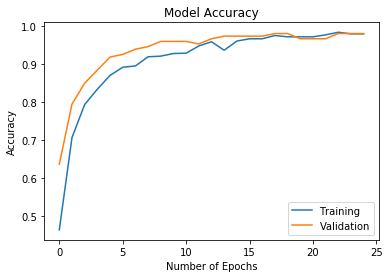

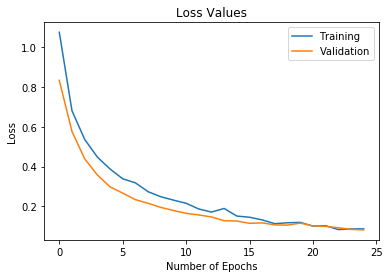

In [ ]:
print("Training History...\n")
plt.plot(history.history["accuracy"],label="Training")
plt.plot(history.history["val_accuracy"],label="Validation")
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Training")
plt.plot(history.history["val_loss"],label="Validation")
plt.title("Loss Values")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Function to detail model performance on test set
def classwise_evaluation(model,data_generator):
  class_labels=data_generator.class_indices
  y_pred=np.argmax(model.predict_generator(data_generator),axis=1).reshape(-1,1)
  y_true=data_generator.classes.reshape(-1,1)

  print("Confusion Matrix")
  cm = confusion_matrix(y_true, y_pred, list(class_labels.values()))
  print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap="gray")
  plt.title('Confusion Matrix',fontsize=20,pad=40)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + list(class_labels.keys()),rotation=25)
  ax.set_yticklabels([''] + list(class_labels.keys()),rotation=25)
  plt.xlabel('Predicted Label',fontsize=13)
  plt.ylabel('True Label',fontsize=13)
  plt.show()

  prevalence=[] 
  sensitivity=[]
  specificity=[]
  precision=[]
  accuracy=[]
  PPV=[]
  NPV=[]
  for class_label in list(class_labels.values()):
    tp=np.sum((y_pred==class_label) & (y_true==class_label))
    fn=np.sum((y_pred!=class_label) & (y_true==class_label))
    fp=np.sum((y_pred==class_label) & (y_true!=class_label))
    tn=np.sum((y_pred!=class_label) & (y_true!=class_label))
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    prevalence.append((tp+fn)/(tp+fp+tn+fn))
    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))
    PPV.append(tp/(tp+fp)) 
    NPV.append(tn/(tn+fn)) 
  results=pd.DataFrame(columns=["Class Encoding","Class Label","Prevalence","Accuracy","Sensitivity","Specificity","PPV","NPV"],
                                  data=zip(list(class_labels.values()),list(class_labels.keys()),prevalence,accuracy,sensitivity,specificity,PPV,NPV))
  results.set_index("Class Encoding",inplace=True)
  print("\n\n",results,"\n\n")
  print("\nOverall Accuracy : ",model.evaluate(data_generator)[1])
  return results




Final Loss,Accuracy on each set :
Training Set : 
37/37 [==============================] - 587s 16s/step - loss: 0.0445 - accuracy: 0.9966
[0.04451075568795204, 0.9965694546699524]
Validation Set : 
19/19 [==============================] - 71s 4s/step - loss: 0.0769 - accuracy: 0.9795
[0.07691827416419983, 0.9794520735740662]


Class wise results on Test set...
Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[47  0  0]
 [ 0 49  0]
 [ 0  5 44]]


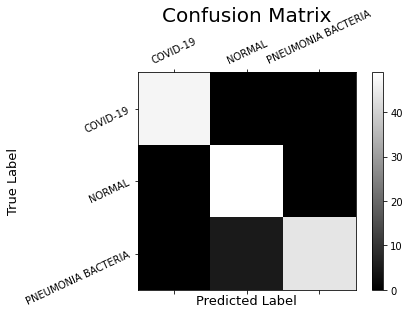



                        Class Label  Prevalence  ...       PPV       NPV
Class Encoding                                  ...                    
0                         COVID-19    0.324138  ...  1.000000  1.000000
1                           NORMAL    0.337931  ...  0.907407  1.000000
2               PNEUMONIA BACTERIA    0.337931  ...  1.000000  0.950495

[3 rows x 7 columns] 


19/19 [==============================] - 3s 181ms/step - loss: 0.0968 - accuracy: 0.9655

Overall Accuracy :  0.9655172228813171


,Class Label,Prevalence,Accuracy,Sensitivity,Specificity,PPV,NPV
Class Encoding,,,,,,,
0,COVID-19,0.324138,1.000000,1.000000,1.000000,1.000000,1.000000
1,NORMAL,0.337931,0.965517,1.000000,0.947917,0.907407,1.000000
2,PNEUMONIA BACTERIA,0.337931,0.965517,0.897959,1.000000,1.000000,0.950495


In [14]:
print("\n\nFinal Loss,Accuracy on each set :")
print("Training Set : ")
train_generator.shuffle=False
print(model.evaluate(train_generator))
print("Validation Set : ")
print(model.evaluate(validation_generator))
print("\n\nClass wise results on Test set...")
results=classwise_evaluation(model,test_generator)
results